# ***Assignment 1.2 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

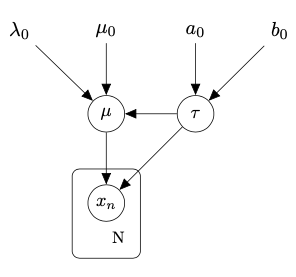

### ***Question 1.2.7:***

Implement a function that generates data points for the given model.

In [2]:
import numpy as np
def generate_data(mu, tau, N):
  # Insert your code here
  sigma = 1 / np.sqrt(tau)
  D = np.random.normal(mu, sigma, N)

  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



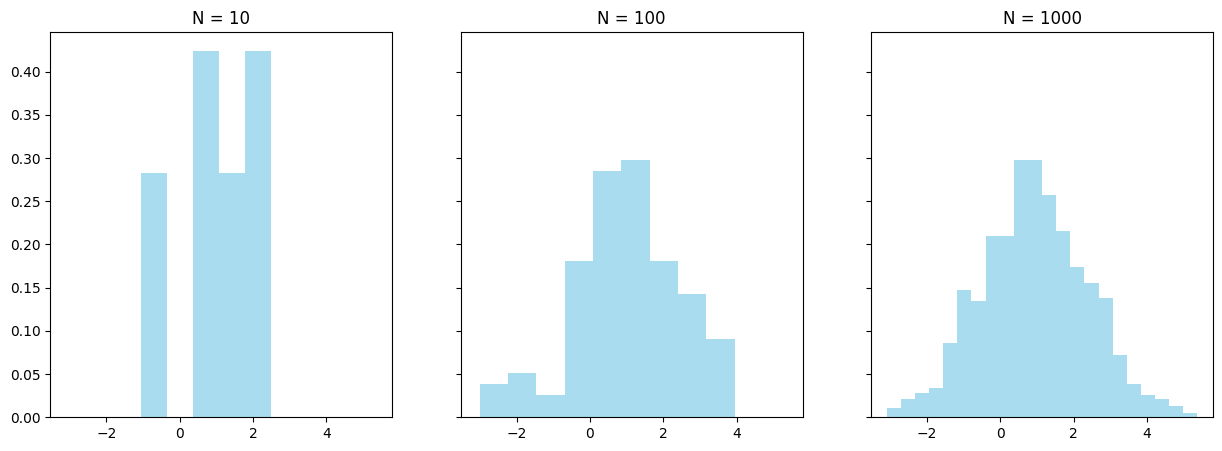

In [151]:
import matplotlib.pyplot as plt
import scipy.stats as stats

mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex='all', sharey='all')
datasets = [dataset_1, dataset_2, dataset_3]

for ax, data in zip(axes, datasets):
    n = len(data)
    ax.hist(data, bins='auto', density=True, alpha=0.7, color='skyblue')
    ax.set_title(f'N = {n}')

plt.show()

### ***Question 1.2.8:***

Find ML estimates of the variables μ and τ

In [152]:
def ML_est(data):
  # insert your code
  mu_ml = np.mean(data)
  tau_ml = 1.0 / np.var(data, ddof=0)
  return mu_ml, tau_ml

### ***Question 1.2.9:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [ ]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
    N = len(D)
    x_bar = np.mean(D)
    sq_sum = np.sum((D - x_bar) ** 2)

    # mu parameters
    lambda_N = lambda_0 + N
    mu_N = (lambda_0 * mu_0 + N * x_bar) / lambda_N

    # tau parameters
    a_N = a_0 + (N + 1) / 2
    b_N = b_0 + 0.5 * (sq_sum + (lambda_0 * N / lambda_N) * (x_bar - mu_0) ** 2)

    return mu_N, lambda_N, a_N, b_N

### ***Question 1.2.10:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [8]:
# prior parameters
mu_0 = 0.0
lambda_0 = 1.0
a_0 = 1.0
b_0 = 1.0

Continue with a helper function that computes ELBO:


In [ ]:
from scipy.stats import gamma, norm
from scipy.special import digamma, gammaln


def compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N):
    N = len(D)

    E_tau = a_N / b_N
    E_ln_tau = digamma(a_N) - np.log(b_N)

    # E[ln p(D|mu,tau)]
    E_likelihood = (
        (N / 2) * E_ln_tau
        - (N / 2) * np.log(2 * np.pi)
        - (E_tau / 2) * (np.sum((D - mu_N) ** 2) + N / lambda_N)
    )

    # E[ln p(mu|tau)]
    E_mu_prior = 0.5 * E_ln_tau + 0.5 * np.log(lambda_0 / (2 * np.pi))
    E_mu_prior -= (E_tau * lambda_0 / 2) * ((mu_N - mu_0) ** 2 + 1 / lambda_N)

    # E[ln p(tau)]
    E_tau_prior = a_0 * np.log(b_0) - gammaln(a_0)
    E_tau_prior += (a_0 - 1) * E_ln_tau - b_0 * E_tau

    # H[q(mu)]
    H_q_mu = 0.5 * (1 + np.log(2 * np.pi / lambda_N))

    # H[q(tau)]
    H_q_tau = a_N - np.log(b_N) + gammaln(a_N) + (1 - a_N) * digamma(a_N)

    return E_likelihood + E_mu_prior + E_tau_prior - H_q_mu - H_q_tau

Now, implement the CAVI algorithm:

In [212]:
def CAVI(D, a_0, b_0, mu_0, lambda_0, max_iter=1000, eps=1e-6, step_size=0.1):
    N = len(D)
    x_bar = np.mean(D)

    # Initialize
    a_N = a_0 + N / 2
    b_N = b_0 + N / 2

    E_tau = a_N / b_N
    lambda_N = lambda_0 + N * E_tau
    mu_N = (lambda_0 * mu_0 + N * x_bar * E_tau) / lambda_N

    elbos = [compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N)]

    for iter in range(max_iter):
        old_b_N = b_N
        old_mu_N = mu_N
        old_lambda_N = lambda_N

        # Update q(tau)
        sq_sum = np.sum((D - mu_N) ** 2)
        new_b_N = b_0 + 0.5 * (sq_sum + N / lambda_N + lambda_0 * (mu_N - mu_0) ** 2)
        b_N = old_b_N + step_size * (new_b_N - old_b_N)

        # Update q(mu)
        E_tau = a_N / b_N
        new_lambda_N = lambda_0 + N * E_tau
        new_mu_N = (lambda_0 * mu_0 + N * x_bar * E_tau) / new_lambda_N

        lambda_N = old_lambda_N + step_size * (new_lambda_N - old_lambda_N)
        mu_N = old_mu_N + step_size * (new_mu_N - old_mu_N)

        elbo = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N)
        elbos.append(elbo)

        if iter > 0 and abs(elbos[-1] - elbos[-2]) < eps:
            break 

    return a_N, b_N, mu_N, lambda_N, elbos

Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.


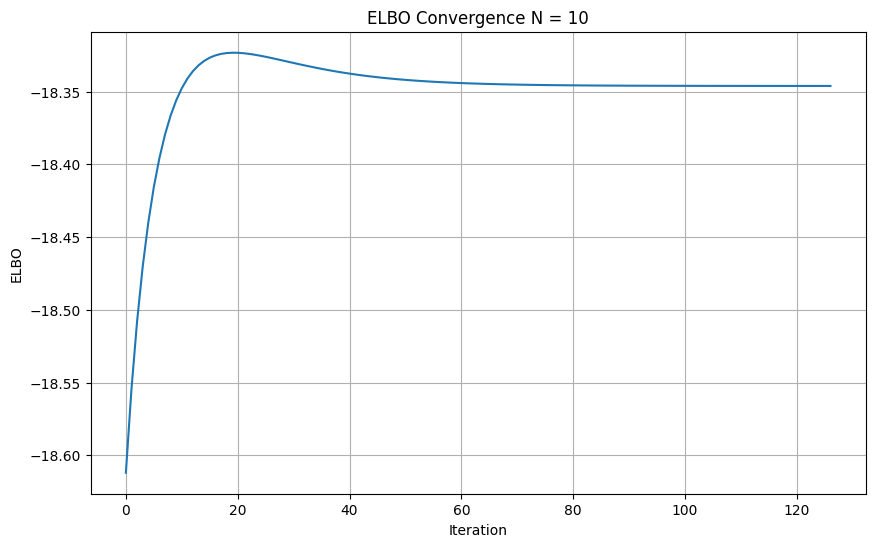

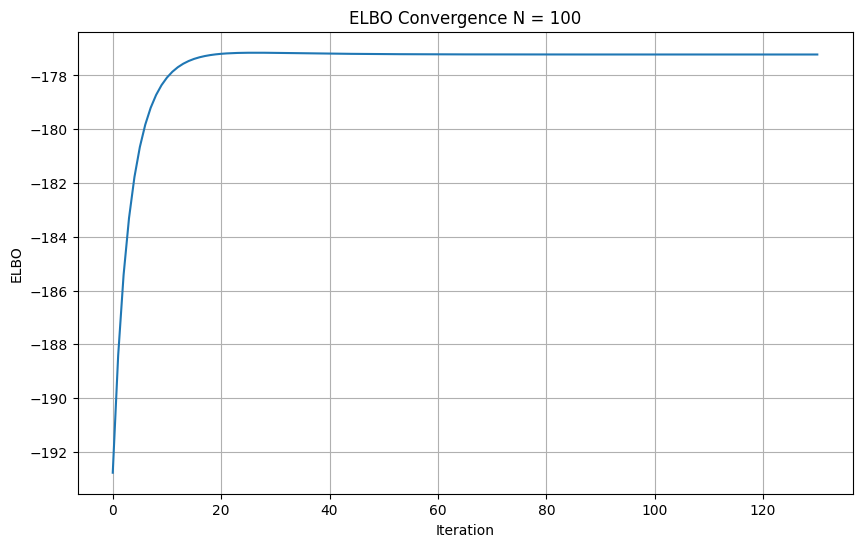

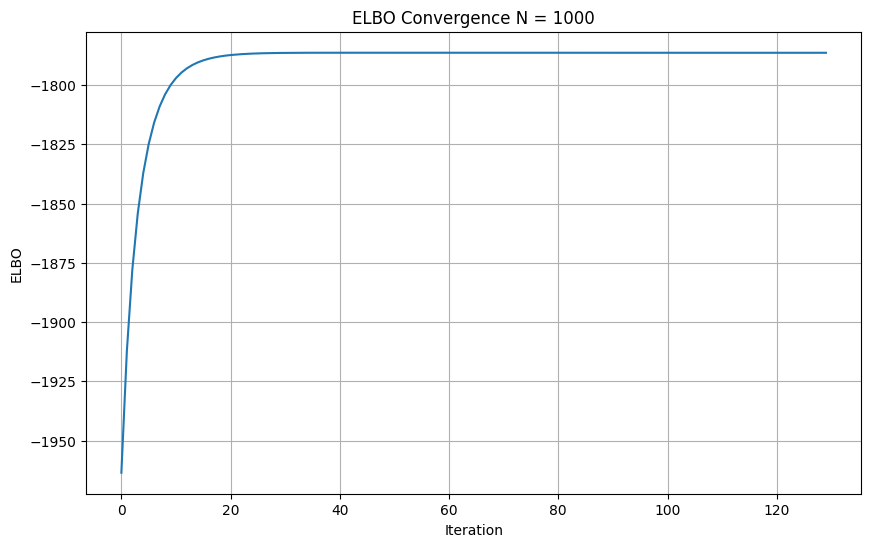

In [218]:
# Insert your main code here

# Convergence

for D in datasets:    
    mu_ml, tau_ml = ML_est(D)
    a_N, b_N, mu_N, lambda_N, elbos = CAVI(D, a_0, b_0, mu_0, lambda_0)
    exact_post = compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0)

    plt.figure(figsize=(10, 6))
    plt.plot(elbos)
    plt.title(f"ELBO Convergence N = {len(D)}")
    plt.xlabel("Iteration")
    plt.ylabel("ELBO")
    plt.grid(True)
    plt.show()

N=10:
  Parameter  True value        ML        VI     Exact
0        mu         1.0  1.036168  0.922428  0.941971
1       tau         0.5  0.932923  0.810983  0.876230


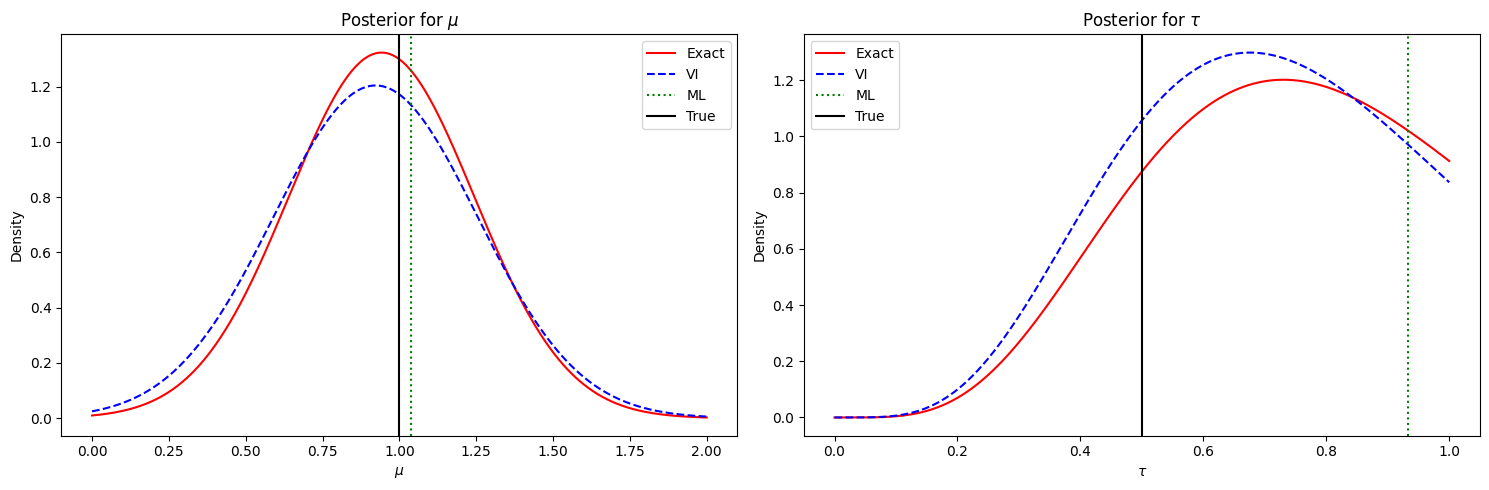

N=100:
  Parameter  True value        ML        VI     Exact
0        mu         1.0  1.035058  1.014883  1.024810
1       tau         0.5  0.505687  0.503032  0.507939


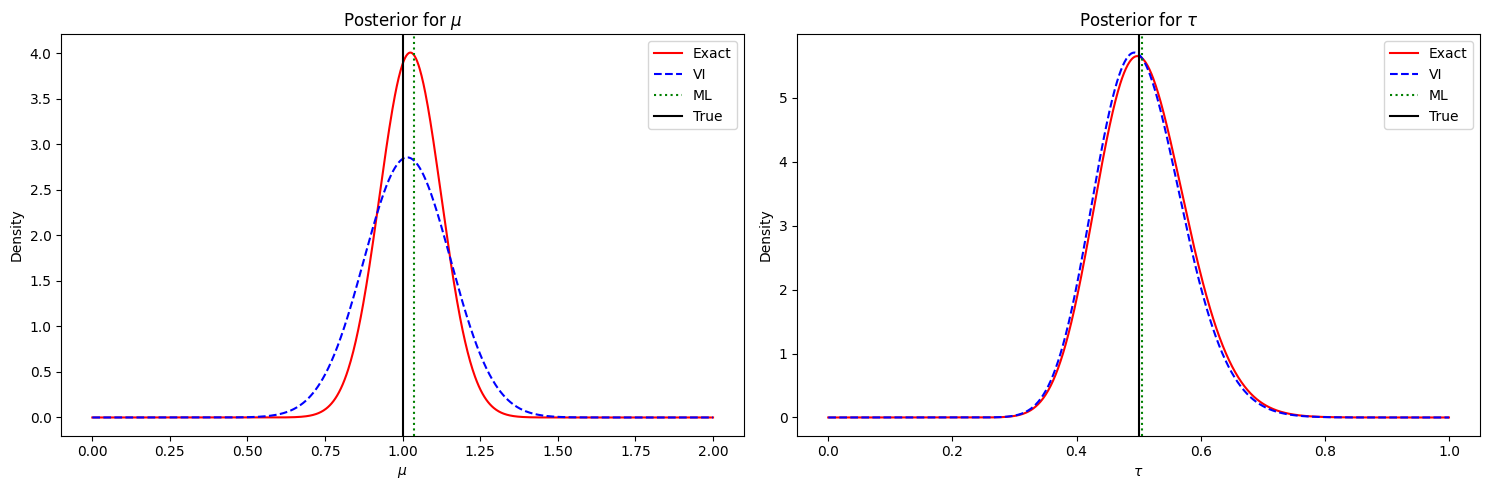

N=1000:
  Parameter  True value        ML        VI     Exact
0        mu         1.0  0.932366  0.930421  0.931435
1       tau         0.5  0.478485  0.478308  0.478785


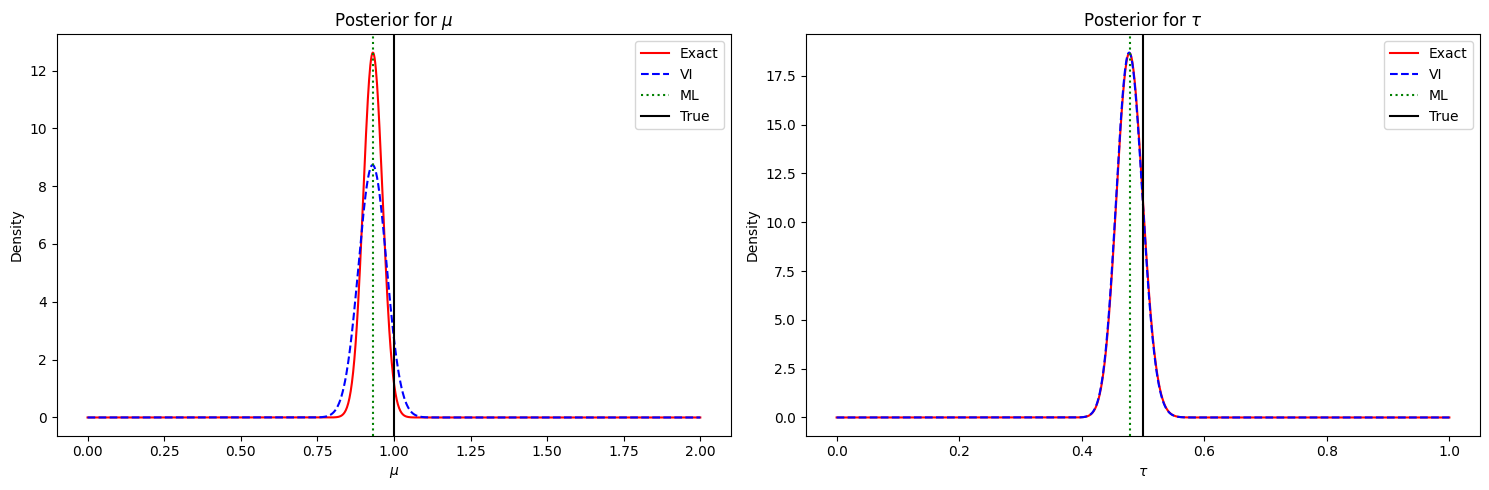

In [255]:
import pandas as pd


def plot_distribution(domain, exact, vi, ml, true, var, ax=None):
    if not ax:
        ax = plt.gca()

    ax.plot(domain, exact, "r-", label="Exact")
    ax.plot(domain, vi, "b--", label="VI")
    ax.axvline(ml, color="g", linestyle=":", label="ML")
    ax.axvline(true, color="k", linestyle="-", label="True")

    ax.set_title(f"Posterior for $\\{var}$")
    ax.set_xlabel(f"$\\{var}$")
    ax.set_ylabel("Density")
    ax.legend()


def posterior_comparison(
    D, a_0=1.0, b_0=1.0, mu_0=0.0, lambda_0=1.0, true_mu=1.0, true_tau=0.5
):
    mu_ml, tau_ml = ML_est(D)
    mu_N_exact, lambda_N_exact, a_N_exact, b_N_exact = compute_exact_posterior(
        D, a_0, b_0, mu_0, lambda_0
    )
    a_N_vi, b_N_vi, mu_N_vi, lambda_N_vi, _ = CAVI(D, a_0, b_0, mu_0, lambda_0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # mu distributions
    mu_grid = np.linspace(0.0, 2.0, 1000)

    exact_mu = stats.norm.pdf(mu_grid, mu_N_exact, 1 / np.sqrt(lambda_N_exact))
    vi_mu = stats.norm.pdf(mu_grid, mu_N_vi, 1 / np.sqrt(lambda_N_vi))

    plot_distribution(mu_grid, exact_mu, vi_mu, mu_ml, true_mu, "mu", ax1)

    tau_grid = np.linspace(0, 1.0, 1000)

    # tau distributions
    exact_tau = stats.gamma.pdf(tau_grid, a_N_exact, scale=1 / b_N_exact)
    vi_tau = stats.gamma.pdf(tau_grid, a_N_vi, scale=1 / b_N_vi)

    plot_distribution(tau_grid, exact_tau, vi_tau, tau_ml, true_tau, "tau", ax2)

    plt.tight_layout()

    result = pd.DataFrame(
        {
            "Parameter": ["mu", "tau"],
            "True value": [true_mu, true_tau],
            "ML": [mu_ml, tau_ml],
            "VI": [mu_N_vi, a_N_vi / b_N_vi],
            "Exact": [mu_N_exact, a_N_exact / b_N_exact],
        }
    )
    print(result)
    plt.show()

for i, D in enumerate(datasets):
    print(f"N={len(D)}:")
    posterior_comparison(D)
    